# SMAI Assignment - 4

## $\color{gold}{\text{Mini-Project: Age Prediction}}$

In [1]:
# Helpful preamble commands and imports for Jupyter notebooks 

# reload notebook automatically after changes to source python files
%load_ext autoreload
%autoreload 2

# standard libraries
from pathlib import Path
import json
from glob import glob
from os.path import join
from pathlib import Path
from tqdm import tqdm
import shutil

# scientific computing
import math
import numpy as np
import pandas as pd
from PIL import Image

# visualization
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
%matplotlib inline

In [2]:
import torch
from torchvision.transforms import Compose, Resize, ToTensor, Normalize

# setting random seed for reproducibility
RANDOM_SEED = 24
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)

KAGGLE = False
if KAGGLE:
    DATA_PATH = Path('/kaggle/input/smai-24-age-prediction/content/faces_dataset/')
else:
    DATA_PATH = Path('data/')

train_path = DATA_PATH / 'train'
train_ann_path = DATA_PATH / 'train.csv'

test_path = DATA_PATH / 'test'
test_ann_path = DATA_PATH / 'submission.csv'

In [3]:
class AgeDataset(torch.utils.data.Dataset):

    def __init__(self, data_path, annot_path, train=True):
        super(AgeDataset, self).__init__()

        self.annot_path = annot_path
        self.data_path = data_path
        self.train = train
        
        self.ann = pd.read_csv(annot_path)
        self.files = self.ann['file_id']
        if train:
            self.ages = self.ann['age']
        self.transform = self._transform(224)

    @staticmethod    
    def _convert_image_to_rgb(image):
        return image.convert("RGB")

    def _transform(self, n_px):
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        return Compose([
            Resize(n_px),
            self._convert_image_to_rgb,
            ToTensor(),
            Normalize(mean, std),
        ])

    def read_img(self, file_name):
        im_path = join(self.data_path,file_name)   
        img = Image.open(im_path)
        img = self.transform(img)
        return img

    def __getitem__(self, index):
        file_name = self.files[index]
        img = self.read_img(file_name)
        if self.train:
            age = self.ages[index]    
            return img, age
        else:
            return img

    def __len__(self):
        return len(self.files)

train_dataset = AgeDataset(train_path, train_ann_path, train=True)
test_dataset = AgeDataset(test_path, test_ann_path, train=False)

In [4]:
from torch.utils.data import random_split

val_size = int(0.2 * len(train_dataset))
train_size = len(train_dataset) - val_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# printing the number of training and test examples
print(f"Number of training examples: {len(train_dataset)}")
print(f"Number of validation examples: {len(val_dataset)}")
print(f"Number of test examples: {len(test_dataset)}")

Number of training examples: 17072
Number of validation examples: 4268
Number of test examples: 1950


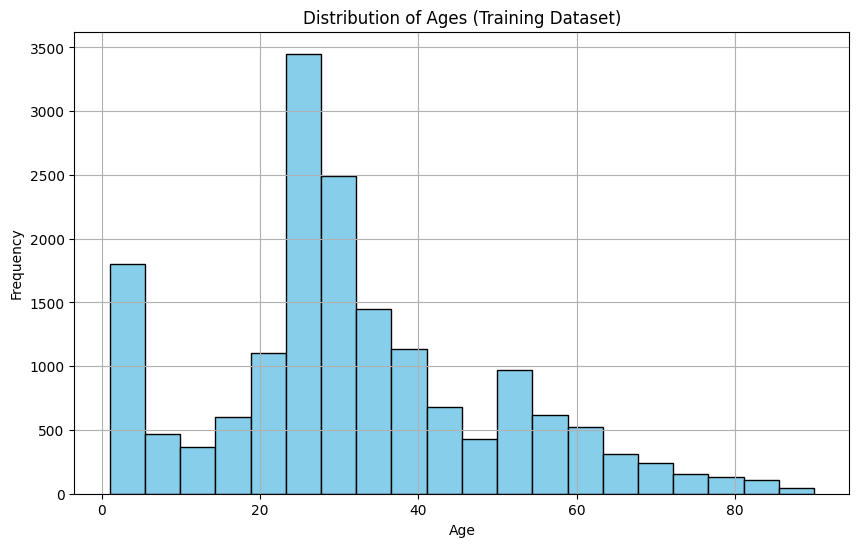

Min Age: 1
Max Age: 90
Percentage of dataset in each age bin:
1.0-9.9: 13.31%
9.9-18.8: 5.65%
18.8-27.700000000000003: 26.66%
27.700000000000003-36.6: 23.10%
36.6-45.5: 10.61%
45.5-54.400000000000006: 8.22%
54.400000000000006-63.300000000000004: 6.71%
63.300000000000004-72.2: 3.22%
72.2-81.10000000000001: 1.65%
81.10000000000001-90.0: 0.87%


In [5]:
def analyze_dataset(dataset, title="Dataset Analysis"):
    # Extract ages from dataset
    ages = [sample[1] for sample in dataset]

    # Plot distribution of ages
    plt.figure(figsize=(10, 6))
    plt.hist(ages, bins=20, color='skyblue', edgecolor='black')
    plt.title(f"Distribution of Ages ({title})")
    plt.xlabel("Age")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

    # Calculate min and max ages
    min_age = min(ages)
    max_age = max(ages)
    print(f"Min Age: {min_age}")
    print(f"Max Age: {max_age}")

    # Calculate bin sizes
    num_bins = 10
    bin_size = (max_age - min_age) / num_bins

    # Count samples in each age bin
    bin_counts = [0] * num_bins
    for age in ages:
        bin_index = min(int((age - min_age) / bin_size), num_bins - 1)
        bin_counts[bin_index] += 1

    # Calculate percentage of dataset in each bin
    total_samples = len(ages)
    bin_percentages = [count / total_samples * 100 for count in bin_counts]

    # Print bin percentages
    print("Percentage of dataset in each age bin:")
    for i, percentage in enumerate(bin_percentages):
        bin_start = min_age + i * bin_size
        bin_end = min_age + (i + 1) * bin_size
        print(f"{bin_start}-{bin_end}: {percentage:.2f}%")
    
analyze_dataset(train_dataset, title="Training Dataset")

In [6]:
train_aug_path = DATA_PATH / 'train_aug_4'
train_aug_ann_path = DATA_PATH / 'train_aug_4.csv'
if train_aug_path.exists():
    shutil.rmtree(train_aug_path)
if train_aug_ann_path.exists():
    train_aug_ann_path.unlink()
train_aug_path.mkdir(parents=True)

df_original = pd.read_csv(train_ann_path)

df_new = pd.DataFrame(columns=['file_id', 'age'])

for index, row in df_original.iterrows():
    image_name = row['file_id']
    age = row['age']
    
    original_image_path = train_path / image_name
    original_image = Image.open(original_image_path)
    
    should_copy = False
    should_augment = False
    if age < 10:
        should_copy = True
        should_augment = False
    elif age >= 10 and age < 20:
        should_copy = True
        should_augment = True
    elif age >= 20 and age < 35:
        should_copy = True
        should_augment = False
    elif age >= 35:
        should_copy = True
        should_augment = True
    
    if should_copy:
        original_image_name = f"orig_{image_name}"
        original_image_path = join(train_aug_path, original_image_name)
        original_image.save(original_image_path)
        df_new.loc[len(df_new)] = [original_image_name, age]
    
    if should_augment:
        # augment the image by flipping it horizontally
        augmented_image = original_image.transpose(Image.FLIP_LEFT_RIGHT)
        augmented_image_name = f"augm_{image_name}"
        augmented_image_path = join(train_aug_path, augmented_image_name)
        augmented_image.save(augmented_image_path)
        df_new.loc[len(df_new)] = [augmented_image_name, age]
        
df_new.to_csv(train_aug_ann_path, index=False)